# Assignment 3

**Submission deadlines:**
- deadline: last lab session Tuesday, 09.04.2023

**Points:** Aim to get 8 points + 2 extra

## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

For the problem 2, we provide the starter code,
however, you are not required to use it as long as you properly solve the tasks.

# Problem 1: Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flower102` class. You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flower102(root='./data', download=True, transform=transforms.ToTensor())
```

In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1.1 **[2p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.

    https://medium.com/@charles.st017/data-wrangling-with-the-oxford-flower-database-learning-how-to-develop-a-machine-learning-pipeline-dbaa28c9ca4
    https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/
    https://www.kdnuggets.com/building-a-convolutional-neural-network-with-pytorch
    https://medium.com/swlh/deep-learning-for-image-classification-creating-cnn-from-scratch-using-pytorch-d9eeb7039c12
    https://colab.research.google.com/drive/1cmn1bZ9_cwmcTYJPl4DsvuHXNEb8-V3I?usp=sharing&source=post_page-----d9eeb7039c12--------------------------------#scrollTo=DUTUbGbUk4ZZ
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    * Train your CNN on a small part of the dataset (e.g., 10%, 25%, 50%, 75%, 100% of the original training set) while keeping the validation and test sets constant.

* 1.2 **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 1.3 **[1p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 1.4 **[1p]**:
    * Modify your CNN architecture to include batch normalization and dropout layers.

* 1.5 **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 1.6 ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

You can use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.




In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login() # klucz - 7242fe50822869937a282970b5385963778c7f8c

wandb: Currently logged in as: michalfica125 (neuralnetworks). Use `wandb login --relogin` to force relogin


True

In [ ]:
from tqdm.auto import tqdm

class InMemDataLoader(object):
    __initialized = False
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
# import wandb
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import Flowers102
import random
from torchsummary import summary

batch_size = 128
train_dataset_size, validation_dataset_size, test_dataset_size = 1020, 1020, 6149
amount_of_training_batches = train_dataset_size / batch_size

image_size = (224, 224)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
default_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
		v2.Resize(224), v2.CenterCrop(224)
])

train_dataset = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=default_transform)
val_dataset = torchvision.datasets.Flowers102(root='./data', split="val", download=True, transform=default_transform)
test_dataset  = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=default_transform)

In [25]:
class Model(nn.Module):
    def __init__(self, dp=0.5):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 102)
        self.do = nn.Dropout(dp)

    def forward(self, x):

        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(self.bn1(x))
        # x = F.relu(x)

        x = F.max_pool2d(self.conv2(x), 2)
        x = F.relu(self.bn2(x))
        # x = F.relu(x)

        x = F.max_pool2d(self.conv3(x), 2)
        x = F.relu(self.bn3(x))
        # x = F.relu(x)

        x = F.max_pool2d(self.conv4(x), 2)
        x = F.relu(self.bn4(x))
        # x = F.relu(x)

        x = F.max_pool2d(self.conv5(x), 2)
        x = F.relu(self.bn5(x))
        # x = F.relu(x)

        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = F.relu(self.bn6(x))
        # x = F.relu(x)

        x = self.do(x) # dropout

        x = self.fc2(x)
        x = F.relu(self.bn7(x))
        # x = F.relu(x)

        x = self.do(x) # dropout

        x = self.fc3(x)
        return x

    def loss(self, Out, Targets):
      return F.cross_entropy(Out, Targets)

model = Model().to(device)
# summary(model, (3,224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 112, 112]              32
            Conv2d-3         [-1, 16, 112, 112]           2,320
       BatchNorm2d-4           [-1, 16, 56, 56]              32
            Conv2d-5           [-1, 32, 56, 56]           4,640
       BatchNorm2d-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 32, 28, 28]           9,248
       BatchNorm2d-8           [-1, 32, 14, 14]              64
            Conv2d-9           [-1, 64, 14, 14]          18,496
      BatchNorm2d-10             [-1, 64, 7, 7]             128
           Linear-11                 [-1, 1024]       3,212,288
      BatchNorm1d-12                 [-1, 1024]           2,048
          Dropout-13                 [-1, 1024]               0
           Linear-14                 [-

In [27]:
with torch.no_grad():
    for name, p in model.named_parameters():
        if 'weight' in name:
            if 'conv' in name:
                print(p.shape)
                f_in = p.shape[1]*p.shape[2]*p.shape[3]
                # p.normal_(0, torch.sqrt(torch.tensor(2./f_in)))
        #     elif 'bn' in name:
        #         p = torch.ones_like(p)
        #     else:
        #         raise Exception('weird weight')

        # elif 'bias' in name:
        #     p.zero_()
        # else:
        #     raise Exception('weird parameter')

torch.Size([16, 3, 3, 3])
torch.Size([16, 16, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([64, 32, 3, 3])


In [ ]:
def train(num_of_epochs, train_loader, opt, print_every=10, device="cpu"):
  model.train()

  for data_loader in data_loaders.values():
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

  min_batch_err = 100

  iter = 0
  for e in range(num_of_epochs):
    model.train()
    print(f"Epoch {e+1}")

    for batch in train_loader:
      x = batch[0].to(device)
      y = batch[1].to(device)
      opt.zero_grad()
      iter += 1

      out = model(x)
      loss = nn.CrossEntropyLoss()(out, y)
      loss.backward()
      opt.step()

      _, pred = out.max(dim=1)
      batch_err = (pred != y).sum().item() / out.size(0)
      min_batch_err = min(min_batch_err, batch_err)

      if iter % print_every == 0:
        print(f"iter = {iter}, batch_err = {batch_err * 100.0}")

    val_err = compute_error_rate(model, data_loader=data_loaders["valid"], device=device)
    print(f"val err = {100*val_err:.2f}")
    wandb.log({'val_err': val_err, 'epoch': e+1})

In [ ]:
def compute_error_rate(model, data_loader, device="cpu"):
  model.eval()

  num_errs, num_examples = 0, 0
  with torch.no_grad():
    for batch in data_loader:

      x, y = batch[0].to(device), batch[1].to(device)
      out = model(x)

      _, pred = out.max(dim=1)
      num_errs += (pred != y.data).sum().item()
      num_examples += x.size(0)

  return num_errs / num_examples

In [ ]:
model = Model().to(device)

with torch.no_grad():
    for name, p in model.named_parameters():
        if 'weight' in name:
            if 'conv' in name:
                f_in = p.shape[1]*p.shape[2]*p.shape[3]
                p.normal_(0, torch.sqrt(torch.tensor(2./f_in)))
            elif 'bn' in name:
                p = torch.ones_like(p)
            elif 'fc' in name:
                f_in = p.shape[1]
                p.normal_(0, torch.sqrt(torch.tensor(2./f_in)))
            else:
                raise Exception('weird weight')

        elif 'bias' in name:
            p.zero_()
        else:
            raise Exception('weird parameter')

In [ ]:
lr = 0.001
weight_decay = 0.001
momentum = 0.
epochs = 40
_device = "cuda"
train_frac = 1.
input_norm = 'std'
augment = False
_print_every = 2
# opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay, momentum = momentum)
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
test_size = int(0.5*len(test_dataset))
test_indices = np.random.permutation(len(test_dataset))[:test_size]

test_dataset_frac = [test_dataset.__getitem__(idx=i) for i in test_indices]


data_loaders = {
    "train": InMemDataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(test_dataset_frac, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/1020 [00:00<?, ?it/s]

<ipython-input-3-7568900500c0>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/3074 [00:00<?, ?it/s]

In [ ]:
# -------------------------------------------- zadanie 1.1
train_size = int(train_frac*len(train_dataset))
train_indices = np.random.permutation(len(train_dataset))[:train_size]

train_dataset_frac = [train_dataset.__getitem__(idx=i) for i in train_indices]

data_loaders["train"] = InMemDataLoader(train_dataset_frac, batch_size=batch_size, shuffle=True)
# --------------------------------------------


  0%|          | 0/1020 [00:00<?, ?it/s]

<ipython-input-3-7568900500c0>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


In [ ]:
# -------------------------------------------- zadanie 1.2
train_mean = torch.zeros(3)
train_std = torch.zeros(3)
train_pixels = 0

for i in range(len(train_dataset)): # for i in train_indices:
    t, _ = train_dataset[i]
    train_mean += t.sum((1, 2))
    train_std += (t*t).sum((1, 2))
    train_pixels += t.shape[1]*t.shape[2]

train_mean /= train_pixels
train_std /= train_pixels
train_std = torch.sqrt(train_std-train_mean*train_mean)

print(train_mean)
print(train_std)

# input normalization
if input_norm == 'none':
    norm_transform = v2.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.])
elif input_norm == 'sub 0.5':
    norm_transform = v2.Normalize(mean=[.5, .5, .5], std=[1., 1., 1.])
elif input_norm == 'mean sub':
    norm_transform = v2.Normalize(mean=train_mean, std=[1., 1., 1.])
elif input_norm == 'std':
    norm_transform = v2.Normalize(mean=train_mean, std=train_std)
else:
    raise Exception('weird input normalization')
# ---------------------------------------------------------------

tensor([0.4703, 0.3986, 0.3177])
tensor([0.2956, 0.2463, 0.2803])


In [ ]:
# -------------------------------------------- zadanie 1.5
aug_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomResizedCrop(size=(224, 224), antialias=True), #(.5, 1.), (.8, 1.25)
    v2.RandomRotation(degrees = 10),
    v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.001, 1.)),
    v2.ColorJitter(brightness=.1, hue=.1)
])
train_dataset = aug_transform(train_dataset)
# ---------------------------------------------------------------

In [ ]:
train_dataset = norm_transform(train_dataset)
val_dataset = norm_transform(val_dataset)
test_dataset = norm_transform(test_dataset)

In [ ]:
data_loaders["train"] = InMemDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_loaders["valid"] = InMemDataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# data_loaders["test"] = InMemDataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/1020 [00:00<?, ?it/s]

<ipython-input-3-7568900500c0>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/1020 [00:00<?, ?it/s]

In [ ]:
run = wandb.init(
    project="Assigmnent3",
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "weight_decay": weight_decay,
        "momentum": momentum,
        "train_dataset portion": train_frac,
        "input_norm":'sub 0.5',
        "batch & dropout": True,
        "augmentation": True
    },
)
wandb.watch(model, F.cross_entropy, log="all")

train(num_of_epochs=epochs, train_loader=data_loaders["train"], opt=opt, print_every=_print_every, device=_device)
test_error_rate = compute_error_rate(model, data_loaders["test"], device=_device)
wandb.log({"test_error_rate": test_error_rate})
print(test_error_rate)

wandb.finish()

Epoch 1
iter = 2, batch_err = 98.4375
iter = 4, batch_err = 99.21875
iter = 6, batch_err = 98.4375
iter = 8, batch_err = 96.7741935483871
val err = 99.02
Epoch 2
iter = 10, batch_err = 94.53125
iter = 12, batch_err = 89.0625
iter = 14, batch_err = 85.9375
iter = 16, batch_err = 87.09677419354838
val err = 99.02
Epoch 3
iter = 18, batch_err = 71.875
iter = 20, batch_err = 71.875
iter = 22, batch_err = 72.65625
iter = 24, batch_err = 70.96774193548387
val err = 99.02
Epoch 4
iter = 26, batch_err = 49.21875
iter = 28, batch_err = 39.84375
iter = 30, batch_err = 47.65625
iter = 32, batch_err = 45.96774193548387
val err = 98.92
Epoch 5
iter = 34, batch_err = 33.59375
iter = 36, batch_err = 25.0
iter = 38, batch_err = 26.5625
iter = 40, batch_err = 27.419354838709676
val err = 98.53
Epoch 6
iter = 42, batch_err = 12.5
iter = 44, batch_err = 15.625
iter = 46, batch_err = 10.9375
iter = 48, batch_err = 16.93548387096774
val err = 95.39
Epoch 7
iter = 50, batch_err = 10.9375
iter = 52, batch_er

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_error_rate,▁
val_err,█████▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
test_error_rate,0.72999
val_err,0.69314


In [ ]:
# komentarze do zadań:
# zad 1.1
# 0.1 batch: 100 -83, valid
# 0.5 batch:        , valid
# 1.0


# -----------------------------------------------------------------------------------------------------------------------
#                                           ZADANIE 1.1 WYNIKI
# -----------------------------------------------------------------------------------------------------------------------

"""  self.model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d((2,2)),

        nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d((4,4)),

        nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d((2,2)),
    ).to(device)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128*8*8, 102)
    ).to(device)"""

#  +--------------------------------------------------------------------------------------------------------------------+
#  |                                                                                                                    |
#  +--------------------------------------------------------------------------------------------------------------------+
#  |  training_data_set  |  best_batch_err (50 epoch)    |   best_valid_err (50 epoch)   |     test_err (50 epoch)      |
#  +--------------------------------------------------------------------------------------------------------------------+
#  |  10%                |          9077.56              |          9074.148             |            0.2               |
#  +--------------------------------------------------------------------------------------------------------------------+
#  |  25%                |          9308.71              |          9074.148             |            0.0               |
#  +--------------------------------------------------------------------------------------------------------------------+
#  |  50%                |          9308.71              |          9074.148             |            0.0               |
#  +--------------------------------------------------------------------------------------------------------------------+
#  |  75%                |          9308.71              |          9074.148             |            0.0               |
#  +--------------------------------------------------------------------------------------------------------------------+
#  |  100%               |          9308.71              |          9074.148             |            0.0               |
#  +--------------------------------------------------------------------------------------------------------------------+

# Problem 2: Reusing a VGG Network [2p]

Training large-scale models takes much time and resources. It also requires caution when picking hyperparameters. It is a common practice to share learned parameters of large models, and reuse them in different tasks. Weight matrices can be shared, even between entirely different frameworks. Further reading: [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792) by Yosinski et al.

Neural networks trained for image classification might be seen as composed of two elements: a feature extractor, and a classifier. The former is typically made of a stack of convolutional layers, while the latter is the last linear layer of the model.

We will focus on the deepest models - VGG16 and/or VGG19. To complete the task, load pre-trained VGG model. Then:
1. **[1p]** Train the classifier part of the network on the
  [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset of images:
  * replace the classifier with a new randomly initialized one, whose output dimensionality matches
    the number of classes of the Caltech101 dataset. You can replace all layers in the classifier
    part of the VGG with just one affine projection into 102 classes.
  * to significantly reduce training time and avoid destroying network weights early in the training,
    train only the weights of the classifier. You can achieve this by applying the optimization only
    to the classifier's parameters.
    
2. **[1p]** Assess the usefulness of using dropout and data augmentation during classifier training.
  
This procedure should quickly give you less than 10% training errors on the Caltech101 dataset!

## Starter Code

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
# import wandb
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import Flowers102
import random
from torchsummary import summary

In [2]:
from torchvision.models.vgg import VGG

In [3]:
CUDA = False

In [4]:
# vgg = VGG("vgg19")
vgg = torchvision.models.vgg19()
if CUDA:
    vgg.cuda()

In [5]:
# List layers in the model
print("Feature layers")
print("--------------")
for layer in  vgg.features:
    print(" {0: <8}  ({1}".format(*str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
 Conv2d    (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 Conv2d    (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 MaxPool2d  (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Conv2d    (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 Conv2d    (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 MaxPool2d  (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 Conv2d    (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 Conv2d    (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 Conv2d    (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 Conv2d    (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 ReLU      (inplace=True)
 MaxPool2d  (kernel_size=2, 

In [6]:
class SubsampledImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indexes, transform, **kwargs):
        super(SubsampledImageDataset, self).__init__(**kwargs)
        self.dataset = dataset
        self.indexes = indexes
        self.transform = transform

    def __getitem__(self, i):
        img, label = self.dataset[self.indexes[i]]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indexes)

In [7]:
#![ -d 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
![ -e 101_ObjectCategories.tar.gz ] || gdown https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
![ -d 101_ObjectCategories ] || tar zxf 101_ObjectCategories.tar.gz

Downloading...
From (original): https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
From (redirected): https://drive.google.com/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv&confirm=t&uuid=d9f78be6-c2e9-408c-9bf1-ccb114685df3
To: /content/101_ObjectCategories.tar.gz
100% 132M/132M [00:01<00:00, 67.5MB/s]


In [8]:
caltech_whole_dataset = torchvision.datasets.ImageFolder("./101_ObjectCategories/")

all_indexes = np.random.permutation(len(caltech_whole_dataset))
train_size = int(len(all_indexes) * 0.8)

caltech_train_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[:train_size],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomResizedCrop(224),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_test_dataset = SubsampledImageDataset(
    caltech_whole_dataset,
    all_indexes[train_size:],
    torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
        ]
    ),
)

caltech_datasets = {
    "train": caltech_train_dataset,
    "test": caltech_test_dataset,
}

In [9]:
batch_size = 64

caltech_loaders = {
    "train": torch.utils.data.DataLoader(
        caltech_datasets["train"], batch_size=batch_size, num_workers=4, shuffle=True
    ),
    "test": torch.utils.data.DataLoader(
        caltech_datasets["test"], batch_size=batch_size, num_workers=4, shuffle=False
    ),
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
train_batch = next(iter(caltech_loaders["train"]))
# common.plotting.plot_mat(to_np(train_batch[0])[:20])

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [11]:
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))


Classifier layers
-----------------
Linear      (in_features=25088, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=4096, bias=True)
ReLU        (inplace=True)
Dropout     (p=0.5, inplace=False)
Linear      (in_features=4096, out_features=1000, bias=True)


In [26]:
# Train only the classifier!
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x)
            _, predictions = outputs.max(dim=1)
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def train(
    model, data_loaders, optimizer, criterion, num_epochs=1, log_every=100, cuda=True
):
    if cuda:
        model.cuda()

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            # model.train_mode()
            epoch += 1
            for x, y in data_loaders["train"]:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
# ----------------------------------------- data augmontation
                pipeline = v2.Compose(
                [v2.RandomHorizontalFlip(p=0.5),
                 v2.RandomRotation(degrees = 10)])

                x = pipeline(x)
# -----------------------------------------------------------
                optimizer.zero_grad()
                out = model.forward(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())


                if iter_ % log_every == 0:
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%".format(
                            iter_, loss.item(), err_rate
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["test"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:


                best_epoch = epoch
                best_val_err = val_err_rate


            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
  """Helper to plot the trainig progress over time."""
  plt.figure(figsize=(16, 4))
  plt.subplot(1, 2, 1)
  train_loss = np.array(history["train_losses"])
  plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  train_errs = np.array(history["train_errs"])
  plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
  val_errs = np.array(history["val_errs"])
  plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
  plt.ylim(0, 0.20)
  plt.legend()

In [32]:
from collections import OrderedDict
# TODO: implement a new classifier using `torch.nn.Sequential` and `torch.nn.Linear`
in_size = 25088
classifier = nn.Sequential(OrderedDict([
                           ('linear1', nn.Linear(in_size, 102)),
                           ('bn1',  nn.BatchNorm1d(5000)),
                           ('relu1', nn.ReLU()),
                           ('dropout1', nn.Dropout(p=.5)),
                           ('linear2', nn.Linear(5000, 102)),
                          #  ('bn2',  nn.BatchNorm1d(250)),
                          #  ('relu2', nn.ReLU()),
                          #  ('dropout2', nn.Dropout(p=.5)),
                          #  ('linear3', nn.Linear(250, 102)),
                           ]))

with torch.no_grad():
    for name, p in classifier.named_parameters():
        if 'weight' in name:
            if 'linear' in name:
                f_in = p.shape[1]
                p.normal_(0, torch.sqrt(torch.tensor(2./f_in)))
            elif 'bn' in name:
                p = torch.ones_like(p)
            else:
                raise Exception('weird weight')

        elif 'bias' in name:
            p.zero_()
        else:
            raise Exception('weird parameter')

Training the model!
You can interrupt it at any time.
Minibatch     50  | loss  4.40 | err rate 87.50%
Minibatch    100  | loss  3.79 | err rate 84.38%
----------------------------------------------------------
After epoch  1 | valid err rate: 74.85% | doing  10 epochs
----------------------------------------------------------
Minibatch    150  | loss  3.67 | err rate 75.00%
Minibatch    200  | loss  3.94 | err rate 75.00%
----------------------------------------------------------
After epoch  2 | valid err rate: 73.97% | doing  10 epochs
----------------------------------------------------------
Minibatch    250  | loss  4.05 | err rate 82.81%
Minibatch    300  | loss  4.05 | err rate 79.69%
----------------------------------------------------------
After epoch  3 | valid err rate: 73.87% | doing  10 epochs
----------------------------------------------------------
Minibatch    350  | loss  3.92 | err rate 82.81%
Minibatch    400  | loss  3.36 | err rate 62.50%
Minibatch    450  | los

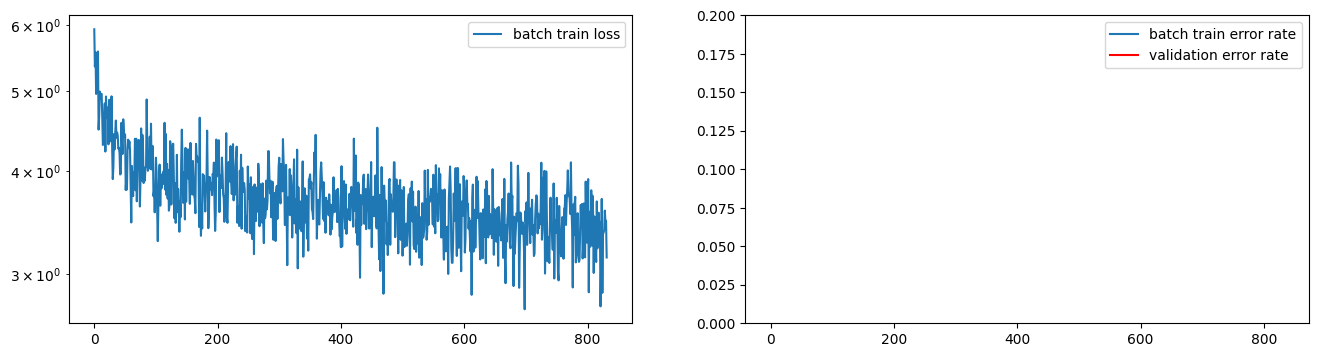

In [33]:
# Replace the classifier of our VGG network
vgg.classifier = classifier

# Disable gradient computation for the all parameter.
# It will speed up the backward pass - the gradient will not be
# backpropagated through the feature extractor.
for p in vgg.parameters():
    p.requires_grad = False

# Reenable gradient computation in our new classifier
for p in vgg.classifier.parameters():
    p.requires_grad = True

criterion = (
    nn.CrossEntropyLoss()
)  # Note: nn.CrossEntropyLoss combines LogSoftmax with NLLLoss

# Train only the params of the classifier
optimizer = torch.optim.Adam(vgg.classifier.parameters(), lr=0.0001)

train(
    vgg, caltech_loaders, optimizer, criterion, num_epochs=10, log_every=50, cuda=True
)